In [94]:
import torch
import torchvision

In [95]:
print(torch.__version__)
print(torchvision.__version__)

2.8.0+cpu
0.23.0+cpu


##### We will continue to build the FoodClassifier Mini version.

It was to classify some images into 3 categories
1. Pizza
2. Sushi
3. Steak

In [96]:
from helper_functions import download_data

image_dir_path = download_data(
    source="https://github.com/harshankbansal/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
    destination="food_dataset"
)

[INFO] data\food_dataset directory exists, skipping download.


## 1. Where to find pre trained models

1. Python domains
2. libraries
3. Hugging face
4. paperswithcode.com

### 1.1 Get a pre trained model
https://docs.pytorch.org/vision/stable/models.html#initializing-pre-trained-models

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [98]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Analyse how the model looks like
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [99]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [100]:
import torchinfo

torchinfo.summary(
    model=model,
    input_size=[1,3,224,224],
    col_names=["input_size", 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## 2. How pre processing works with pre trained models

https://docs.pytorch.org/vision/stable/models.html#using-the-pre-trained-models
We have two options
1. Manual transformation
    1. Define transformation like we did for custom food 
    1. Resizing based on model input, which are always greater then 224X224
    1. The tensors should be normalized using the following transformation
        ```py
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
        ```

2. AUto transformation
    1. All the necessary information for the inference transforms of each pre-trained model is provided on its weights documentation. To simplify inference, TorchVision bundles the necessary preprocessing transforms into each model weight. These are accessible via the weight.transforms attribute:


        ```py
        # Initialize the Weight Transforms
        weights = ResNet50_Weights.DEFAULT
        preprocess = weights.transforms()
        # Apply it to the input image
        img_transformed = preprocess(img)
        ```

In [101]:
# We will use method 2

transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [102]:
# Getting Dataloaders

try:
    from going_modular.going_modular import data_setup
except ImportError:
    print('Python imports are bad')
    import os
    import sys
    from pathlib import Path
    sys.path.append(str(Path(os.path.abspath('')).parent))
    from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names  = data_setup.create_dataloaders(
    batch_size=16,
    train_dir=image_dir_path / "train",
    test_dir=image_dir_path / "test",
    transform=transforms,
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x18026362360>,
 ['pizza', 'steak', 'sushi'])

## 3. Updating the pre trained model layers for our use case

### 3.1 Locking base layers of the pre trained models
As seen above, most of the layers are trainable, however for transfer learning we would like to freeze all of them except the `classifier` layers
A.K.A get it in feature extraction mode

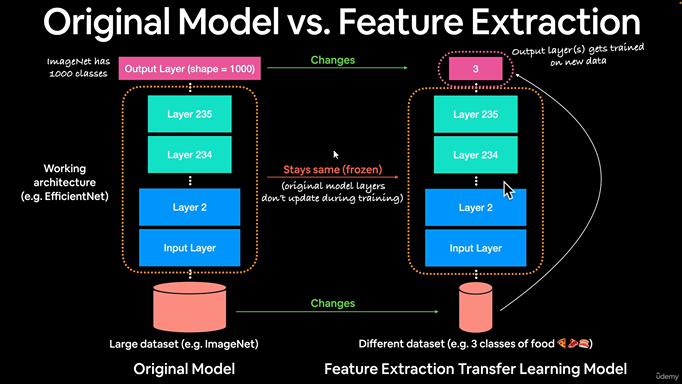

Difference between transfer learning and fine tuning is that with fine tuning, we `unlock` more deeper layers to be traininable, which maybe a better option if we have a high number of training data

In [103]:
#Locking / Freezing the `features` layer in the EffNet
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [104]:
for param in model.features.parameters():
    param.requires_grad = False

torchinfo.summary(
    model=model,
    input_size=[1,3,224,224],
    col_names=["input_size", 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names'],
    depth=5
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Update classifier layer

In [105]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [106]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [107]:
torchinfo.summary(
    model=model,
    input_size=[1,3,224,224],
    col_names=["input_size", 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names'],
    depth=5
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Lets Train

In [108]:
# Define loss and optimizer

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = 0.001
)

In [109]:
from helper_functions import PytorchModelTranier, set_seeds

model_trainer = PytorchModelTranier(
    name='pre-trained-effnet-b0-default-weighs',
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    logits_to_pred=lambda logits: nn.functional.softmax(logits, dim=1).argmax(dim=1)
)

model_trainer

In [110]:
model_trainer.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 1.0189 | Train Acc: 54.58% Test Loss: 0.8289 | Test Acc: 75.91%
Epoch 2/10 Train Loss: 0.7828 | Train Acc: 71.25% Test Loss: 0.6703 | Test Acc: 87.61%
Epoch 3/10 Train Loss: 0.6219 | Train Acc: 85.00% Test Loss: 0.5786 | Test Acc: 85.68%
Epoch 4/10 Train Loss: 0.5567 | Train Acc: 80.83% Test Loss: 0.5302 | Test Acc: 90.11%
Epoch 5/10 Train Loss: 0.5505 | Train Acc: 79.58% Test Loss: 0.4856 | Test Acc: 90.11%
Epoch 6/10 Train Loss: 0.4419 | Train Acc: 85.42% Test Loss: 0.4858 | Test Acc: 86.36%
Epoch 7/10 Train Loss: 0.4444 | Train Acc: 84.58% Test Loss: 0.4488 | Test Acc: 85.11%
Epoch 8/10 Train Loss: 0.3916 | Train Acc: 87.08% Test Loss: 0.3934 | Test Acc: 88.18%
Epoch 9/10 Train Loss: 0.3912 | Train Acc: 85.00% Test Loss: 0.4523 | Test Acc: 83.86%
Epoch 10/10 Train Loss: 0.3654 | Train Acc: 93.33% Test Loss: 0.3826 | Test Acc: 87.61%


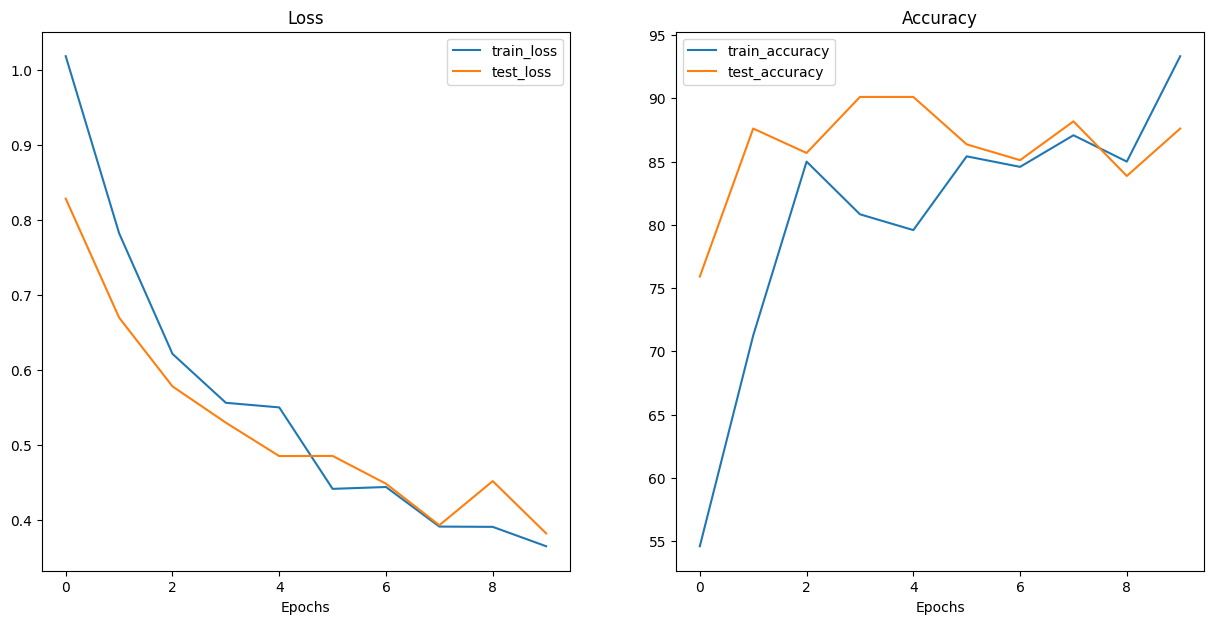

In [111]:
model_trainer.plot_losses()